# Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from experiments import experiments_matching
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'helvetica'

plt.rcParams["font.family"] = "helvetica"
from experiments.plot import log_log, yticks, xticks
%config InlineBackend.figure_formats = ['svg']


def get_best_per_n_train(model, config):
    experiments = experiments_matching(model_type=model, config=config)

    df = pd.DataFrame([{
        **exp['config'], 
        'train': exp['results']['testing']['train_set']['mae']*1000,
        'test': exp['results']['testing']['test_set']['mae']*1000,
        **{
            f'cn_{i}': exp['results']['testing']['test_set'][f'cn_{i}_mae'] 
            for i in (2, 3, 4)
        },
        } for exp in experiments
    ]).fillna(0)

    to_group = list(set(df.columns) - set(['fold', 'train', 'test', *(f'cn_{i}' for i in (2, 3, 4))]))
    cross_validated = df.groupby(to_group).mean()\
        .drop(['fold'], axis=1).reset_index()
    best = cross_validated\
        .loc[cross_validated.groupby(['n_train'])['test'].idxmin()]\
            .reset_index(drop=True).sort_values('n_train')
    best = best[best.n_train <= 1_000_000]
    return best[['n_train', 'test', *(f'cn_{i}' for i in (2, 3, 4))]]

def add_to_plot(model, n_max, l_max, config=None, just_scatter=False, _n_min=80, _n_max=1_000_000, **kwargs):
    if config is None: config = {}
    kwargs = {**dict(marker='o', linewidth=2), **kwargs}
    config = dict(n_max=n_max, l_max=l_max, train_on_equal_cns=False, **config)
    df = get_best_per_n_train(model, config)
    if len(df) == 0:
        return
    df = df[df.n_train >= _n_min]
    df = df[df.n_train <= _n_max]
    df = df[~df.n_train.isin([2_000, 5_000, 30_000, 3160 ])]
    if just_scatter:
        plt.scatter(df.n_train, df.test, **kwargs)
    else:
        plt.plot(df.n_train, df.test, **kwargs)

def add_to_plot_by_cn(model, n_max, l_max, styles=None, config=None, **kwargs):
    if config is None: config = {}
    config = dict(n_max=n_max, l_max=l_max, train_on_equal_cns=False, **config)
    df = get_best_per_n_train(model, config)
    df = df[(df.n_train > 80) & (df.n_train != 5000)]
    
    if styles is None:
        styles = dict()
    defaults = dict(marker='o', linewidth=2)

    for i in (2, 3, 4):
        plt.plot(df.n_train, df[f'cn_{i}']*1000, **{**defaults, **kwargs, **styles.get(i, dict())})


def show_plot():
    log_log()
    yticks([10, 20, 40, 80, 160, 320, 640])
    xticks([100, 1000, 10000, 100000, 1000000], labels=[fr'$10^{{{i}}}$' for i in [2, 3, 4, 5, 6]])
    # xticks([100, 1000, 10000, 100000, 1000000], labels=['100', '1,000', '10,000', '100,000', '1M'])
    plt.xlabel('Number of Training Points')
    plt.ylabel('MAE (meV)')
    plt.ylim(bottom=10)
    s = 3
    plt.xlim(100 / s, 1_000_000 * s)

/opt/miniconda3/envs/synth-exp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plots

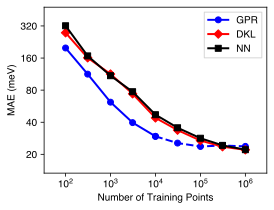

In [3]:
n_max, l_max = 12, 6

plt.figure(dpi=200, figsize=(4, 3))
add_to_plot('gpr', n_max, l_max, c='blue', label='GPR', _n_max=1e4, )
add_to_plot('gpr', n_max, l_max, c='blue', _n_min=1e4, _n_max=1e6, linestyle='--', )
add_to_plot('dkl', n_max, l_max, c='red', label='DKL', marker="D", )
add_to_plot('nn', n_max, l_max, c='black', label='NN', marker="s", )
plt.legend(fancybox=False)
show_plot()
s = 1.5
plt.ylim(20 / s, 320 * s)
plt.savefig("n-train.png", bbox_inches='tight', dpi=200)

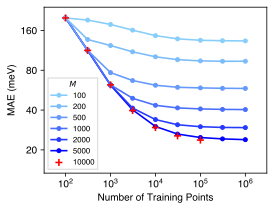

In [4]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

plt.figure(dpi=200, figsize=(4, 3))
n_max, l_max = 12, 6
ms = [100, 200, 500, 1_000, 2_000, 5_000, 10_000]

positions = np.linspace(0, 1, len(ms)-1) ** 1.5
_cmap = LinearSegmentedColormap.from_list('mycmap', ["lightskyblue", "blue"])(positions)
for m, c in zip(ms[:-1], _cmap):
    add_to_plot('gpr', n_max, l_max, c=c, config=dict(m_sparse=m), label=m, zorder=-m, markersize=4, linewidth=1.6)

add_to_plot('gpr', n_max, l_max, color='red', marker='+', s=50, config=dict(m_sparse=10_000), label=10_000, just_scatter=True, linewidth=1.6)

legend = plt.legend(title=r'$\it{M}$', fancybox=False, prop={'size': 7.8})
plt.setp(legend.get_title(),fontsize='8')

show_plot()
s = 1.5
plt.ylim(20 / s, 160 * s)
plt.savefig('m_sparse.png', bbox_inches="tight", dpi=200)